# **YouTube Thumbnail Optimization: A/B Testing**

#### This project analyzes whether Thumbnail A or Thumbnail B generates a higher Click-Through Rate (CTR) on YouTube videos using A/B testing.

### 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### 2. Creating Synthetic Dataset

In [2]:
np.random.seed(42) 

# Number of impressions per group
n_per_group = 10000

In [3]:
# CTR for each group
ctr_A = 0.08  # 8% baseline
ctr_B = 0.10  # 10% with new thumbnail

In [4]:
# Simulate clicks (binary)
clicked_A = np.random.binomial(1, ctr_A, n_per_group)
clicked_B = np.random.binomial(1, ctr_B, n_per_group)

In [5]:
# simulate watch time (seconds)
watch_A = np.random.normal(60, 20, n_per_group).clip(min=5)
watch_B = np.random.normal(65, 20, n_per_group).clip(min=5)

In [6]:
# simulate likes
likes_A = np.random.binomial(1, 0.02, n_per_group)
likes_B = np.random.binomial(1, 0.03, n_per_group)

In [7]:
# Create dataframes
df_A = pd.DataFrame({
    "impression_id": np.arange(n_per_group),
    "group": "A",
    "clicked": clicked_A,
    "watch_time_sec": watch_A,
    "likes": likes_A
})

df_B = pd.DataFrame({
    "impression_id": np.arange(n_per_group, 2*n_per_group),
    "group": "B",
    "clicked": clicked_B,
    "watch_time_sec": watch_B,
    "likes": likes_B
})

In [8]:
df = pd.concat([df_A, df_B]).reset_index(drop=True)

In [9]:
df.to_csv("youtube_ab_test_dataset.csv", index=False)
df.head()

,impression_id,group,clicked,watch_time_sec,likes
0,0,A,0,43.923936,0
1,1,A,1,71.719835,0
2,2,A,0,86.125610,0
3,3,A,0,35.461686,0
4,4,A,0,94.246155,0


### 3. Exploratory Data Analysis (EDA)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   impression_id   20000 non-null  int64  
 1   group           20000 non-null  object 
 2   clicked         20000 non-null  int32  
 3   watch_time_sec  20000 non-null  float64
 4   likes           20000 non-null  int32  
dtypes: float64(1), int32(2), int64(1), object(1)
memory usage: 625.1+ KB


In [11]:
df.shape

(20000, 5)

In [12]:
df.describe()

,impression_id,clicked,watch_time_sec,likes
count,20000.000000,20000.00000,20000.000000,20000.000000
mean,9999.500000,0.09035,62.390815,0.024450
std,5773.647028,0.28669,20.128367,0.154445
min,0.000000,0.00000,5.000000,0.000000
25%,4999.750000,0.00000,48.598375,0.000000
50%,9999.500000,0.00000,62.356116,0.000000
75%,14999.250000,0.00000,76.178422,0.000000
max,19999.000000,1.00000,149.581685,1.000000


In [13]:
df.isnull().sum()

impression_id     0
group             0
clicked           0
watch_time_sec    0
likes             0
dtype: int64

In [14]:
df['group'].value_counts()

group
A    10000
B    10000
Name: count, dtype: int64

In [15]:
#Checking overall CTR per group
#I want to see how many clicks happened in A vs B and compute CTR.
summary = df.groupby("group")["clicked"].agg(["count", "sum", "mean"]).rename(columns={"sum":"clicks", "mean":"CTR"})
print(summary)

       count  clicks     CTR
group                       
A      10000     786  0.0786
B      10000    1021  0.1021


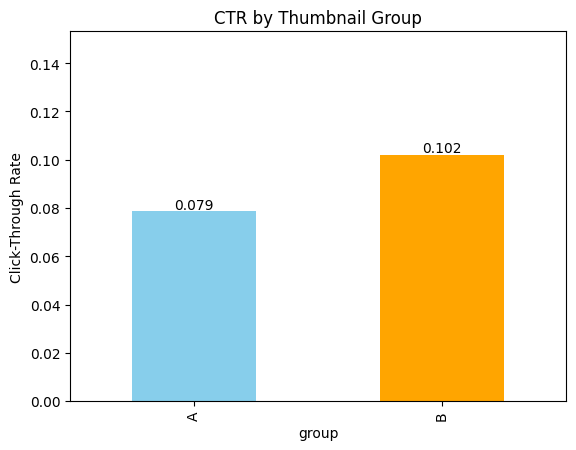

In [16]:
summary["CTR"].plot(kind="bar", color=['skyblue','orange'], legend=False)
plt.title("CTR by Thumbnail Group")
plt.ylabel("Click-Through Rate")
plt.ylim(0, max(summary["CTR"])*1.5)
for i, v in enumerate(summary["CTR"]):
    plt.text(i, v + 0.001, f"{v:.3f}", ha='center')
plt.show()

In [17]:
# Checking secondary metrics
# Average watch time per group
print(df.groupby("group")["watch_time_sec"].mean())

# Average likes per group
print(df.groupby("group")["likes"].mean())

group
A    60.081436
B    64.700194
Name: watch_time_sec, dtype: float64
group
A    0.0188
B    0.0301
Name: likes, dtype: float64


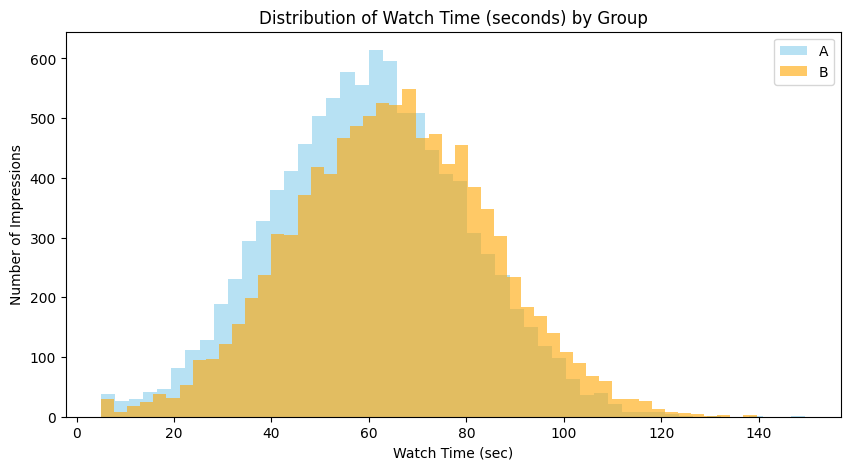

In [18]:
# Histogram of Watch Time per Group
plt.figure(figsize=(10,5))
plt.hist(df[df.group=="A"]["watch_time_sec"], bins=50, alpha=0.6, label='A', color='skyblue')
plt.hist(df[df.group=="B"]["watch_time_sec"], bins=50, alpha=0.6, label='B', color='orange')
plt.title("Distribution of Watch Time (seconds) by Group")
plt.xlabel("Watch Time (sec)")
plt.ylabel("Number of Impressions")
plt.legend()
plt.show()

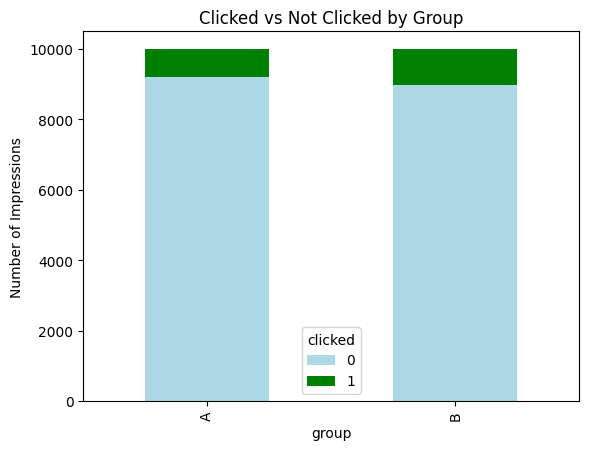

In [19]:
# Click vs No-Click Count per Group
click_counts = df.groupby(["group","clicked"]).size().unstack()
click_counts.plot(kind="bar", stacked=True, color=['lightblue','green'])
plt.title("Clicked vs Not Clicked by Group")
plt.ylabel("Number of Impressions")
plt.show()

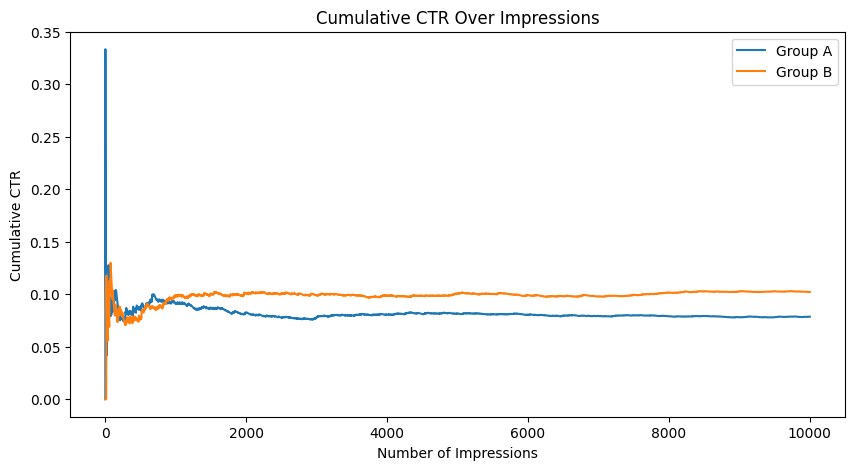

In [20]:
# Cumulative CTR Over Impressions
# Checking if CTR stabilizes over time (like real-time monitoring).
df = df.sample(frac=1).reset_index(drop=True)  # shuffle to simulate timeline
df["cum_clicks"] = df.groupby("group")["clicked"].cumsum()
df["cum_impressions"] = df.groupby("group").cumcount() + 1
df["cum_CTR"] = df["cum_clicks"] / df["cum_impressions"]

plt.figure(figsize=(10,5))
for g in ["A","B"]:
    subset = df[df.group==g]
    plt.plot(subset["cum_impressions"], subset["cum_CTR"], label=f'Group {g}')
plt.title("Cumulative CTR Over Impressions")
plt.xlabel("Number of Impressions")
plt.ylabel("Cumulative CTR")
plt.legend()
plt.show()

The cumulative CTR plot shows that after an initial fluctuation (0–2000 impressions), the lines stabilize. Thumbnail B (orange) consistently achieves a higher CTR than Thumbnail A (blue) across all impressions. This indicates that the performance gap is not due to chance but remains consistent as more data accumulates.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21060\2473530910.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="group", y="watch_time_sec", data=df, palette=["skyblue","orange"])


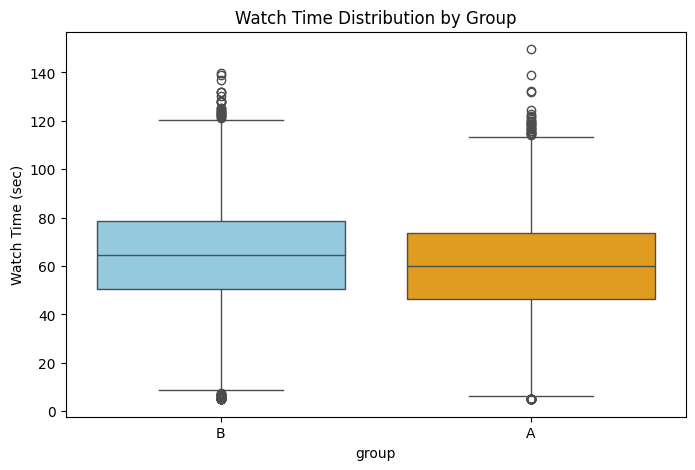

In [21]:
# Boxplot of Watch Time
# Compare distributions and see if B affects watch time variability.
plt.figure(figsize=(8,5))
sns.boxplot(x="group", y="watch_time_sec", data=df, palette=["skyblue","orange"])
plt.title("Watch Time Distribution by Group")
plt.ylabel("Watch Time (sec)")
plt.show()

### 4. Statistical Testing

#### a) Two-Proportion Z-Test
We want to test:

H0: CTR_B = CTR_A → no difference
<br> H1: CTR_B > CTR_A → new thumbnail is better

In [22]:
# Summary stats
summary = df.groupby("group")["clicked"].agg(["count", "sum", "mean"]).rename(columns={"sum":"clicks", "mean":"CTR"})
count = summary["clicks"].values
nobs = summary["count"].values

# Pooled proportion
p_pool = count.sum() / nobs.sum()

# Standard error
se = (p_pool * (1 - p_pool) * (1/nobs[0] + 1/nobs[1]))**0.5

# z-statistic
z_stat = (summary.loc["B","CTR"] - summary.loc["A","CTR"]) / se

# p-value (one-tailed)
p_value = 1 - stats.norm.cdf(z_stat)

print(f"CTR A: {summary.loc['A','CTR']:.3f}, CTR B: {summary.loc['B','CTR']:.3f}")
print(f"z-statistic = {z_stat:.3f}, p-value = {p_value:.4f}")

CTR A: 0.079, CTR B: 0.102
z-statistic = 5.796, p-value = 0.0000


#### b) 95% Confidence Interval for CTR Difference

In [23]:
diff = summary.loc["B","CTR"] - summary.loc["A","CTR"]
se_diff = (summary.loc["A","CTR"]*(1-summary.loc["A","CTR"])/nobs[0] + summary.loc["B","CTR"]*(1-summary.loc["B","CTR"])/nobs[1])**0.5

ci_low = diff - 1.96*se_diff
ci_high = diff + 1.96*se_diff

print(f"Observed CTR difference = {diff:.3f}")
print(f"95% Confidence Interval = [{ci_low:.3f}, {ci_high:.3f}]")

Observed CTR difference = 0.023
95% Confidence Interval = [0.016, 0.031]


#### c) Bootstrap Method

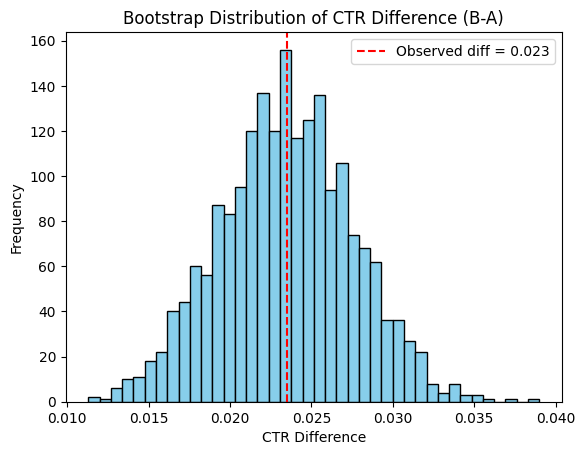

Bootstrap 95% CI: [0.016, 0.031]


In [24]:
def bootstrap_diff(df, n_boot=2000):
    diffs = []
    for _ in range(n_boot):
        sample_A = df[df.group=="A"].sample(frac=1, replace=True)["clicked"]
        sample_B = df[df.group=="B"].sample(frac=1, replace=True)["clicked"]
        diffs.append(sample_B.mean() - sample_A.mean())
    return np.array(diffs)

boot_diffs = bootstrap_diff(df)

# Plot bootstrap distribution
import matplotlib.pyplot as plt

plt.hist(boot_diffs, bins=40, color='skyblue', edgecolor='black')
plt.axvline(diff, color='red', linestyle='--', label=f'Observed diff = {diff:.3f}')
plt.title("Bootstrap Distribution of CTR Difference (B-A)")
plt.xlabel("CTR Difference")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Bootstrap 95% CI
ci_boot = np.percentile(boot_diffs, [2.5, 97.5])
print(f"Bootstrap 95% CI: [{ci_boot[0]:.3f}, {ci_boot[1]:.3f}]")


### 5. Results & Interpretation

- Descriptive Statistics:

Thumbnail A CTR = 7.9%

Thumbnail B CTR = 10.2%

Thumbnail B performed better by 2.3 percentage points.

- Hypothesis Test (Z-test):

Z-statistic = 5.796, p-value = 0.0000

Since p-value < 0.05, we reject the null hypothesis.

This means the difference in CTR between Thumbnail A and B is statistically significant.

- Confidence Interval:

95% CI for the CTR difference = [0.016, 0.031]

Since the interval is entirely positive, we are confident that Thumbnail B consistently outperforms Thumbnail A.

- Bootstrap Validation:

Bootstrap 95% CI = [0.016, 0.031], same as analytical CI.

Confirms robustness of the result.


### 6. Conclusion:

Thumbnail B has a significantly higher CTR compared to Thumbnail A.

With a difference of about 2.3%, we recommend using Thumbnail B in YouTube campaigns for better audience engagement.